# Analysis of June 13th 2022 Flight

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots

In [15]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

In [2]:
df = main.get_data("Alton", "june13_2022.BIN")

Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: Createv2022Dataflash
ArdupilotDFReader - INFO     - Begin processing /Users/williamkemp/Records/Repositories/CREATeV_power/data/june13_2022.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=0
ArdupilotDFReader - INFO     - 2022-06-13 09:13:29.200000 at board time = 1970-01-01 01:38:56.391850


In [5]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.7 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

In [29]:
### Mask Initialization ###

mask = np.array([[5755,6340],
                [6350,6940],
                [6950,7540],
                [7550,8140],
                [8150,8740],
                [8750,9340],
                [9350,9940],
                [9950,10540]])

In [34]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())                      # Bank angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"]
v_esc = df["EscVoltage"]
J = v_tas / (n * prop.diameter)

# Estimated propulsive power
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_12486/3463579551.py:16: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_12486/3463579551.py:16: RuntimeWarning: invalid value encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:33: RuntimeWarning: divide by zero encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:33: RuntimeWarning: invalid value encountered in multiply
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/motors.py:38: RuntimeWarning: divide by zero encountered in reciprocal
  efficiency = (1 - (i0/current)) * (Kv/Kq) * (1 + tau*omega + current*R*Kv*omega**

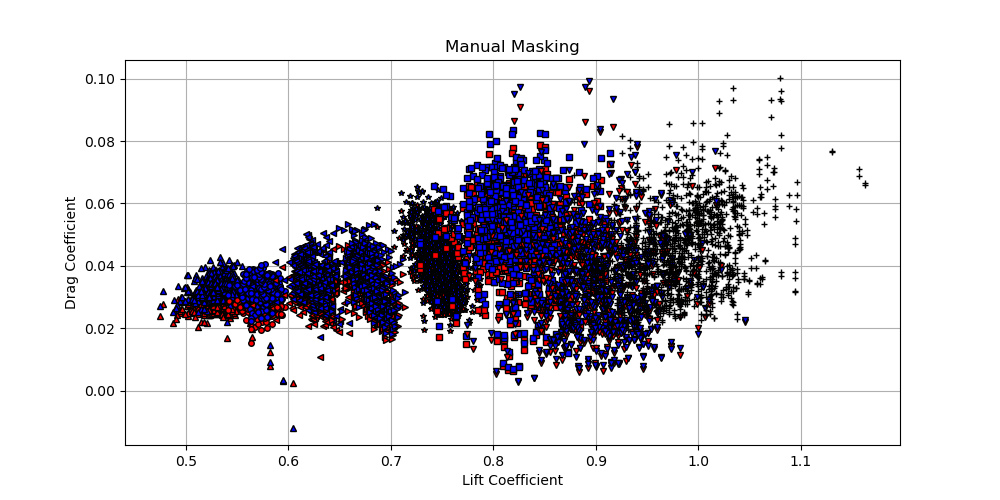

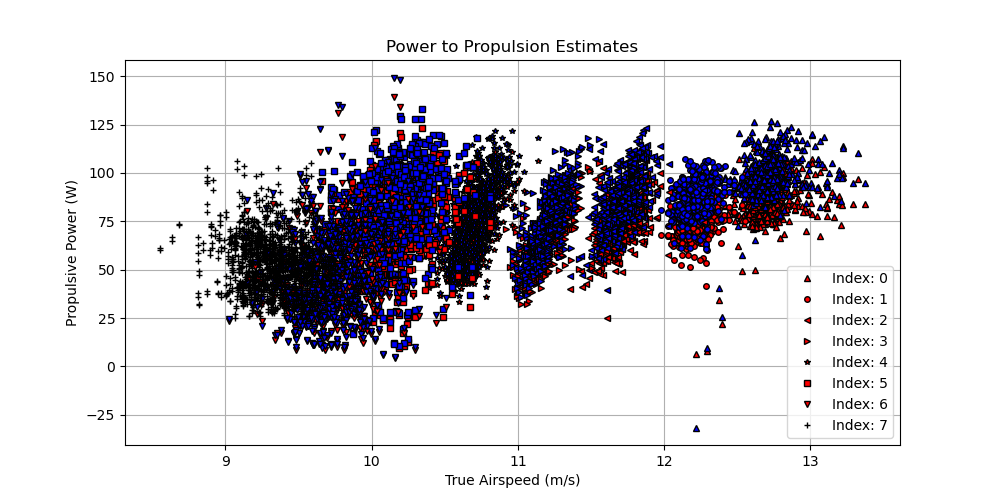

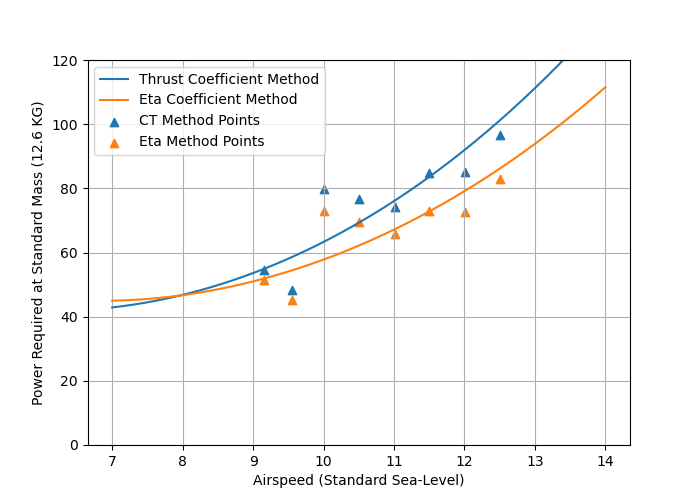

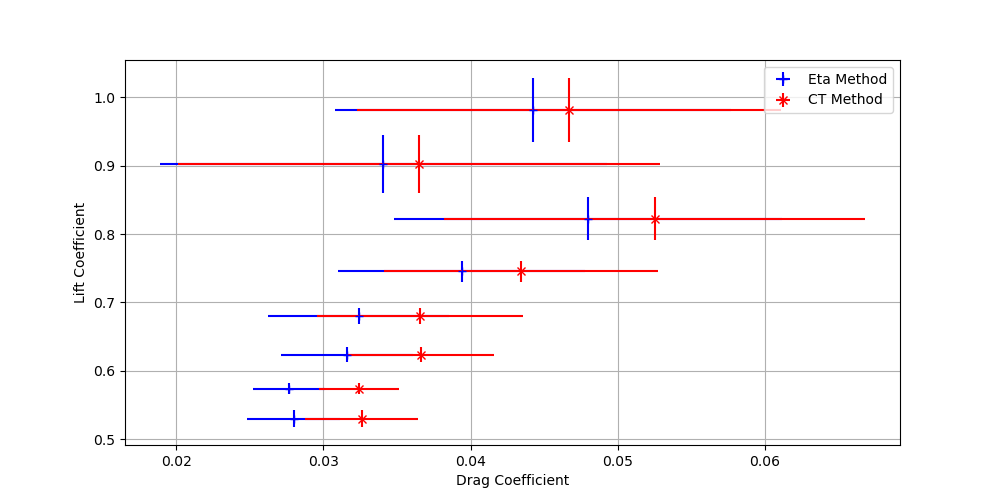

In [39]:

# Plot with static masking
plt.figure(figsize=(10,5))
plt.title("Manual Masking")

markers = ['^', 'o', '<', '>', '*', 's', 'v', '+', 'x', 'D', '.']

for i in range(len(mask)):
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_eta[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Power to Propulsion Estimates")
for i in range(len(mask)):
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Propulsive Power (W)")
plt.legend()
plt.show()

CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))
CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])
    
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (7,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (7,14))

plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method")
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method")
plt.scatter(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='CT Method Points')
plt.scatter(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='Eta Method Points')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0,120])
plt.legend()
plt.grid(True)
plt.show()
    
plt.figure(figsize=(10,5))
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='+b', label="Eta Method")
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='xr', label="CT Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Advance Ratio')

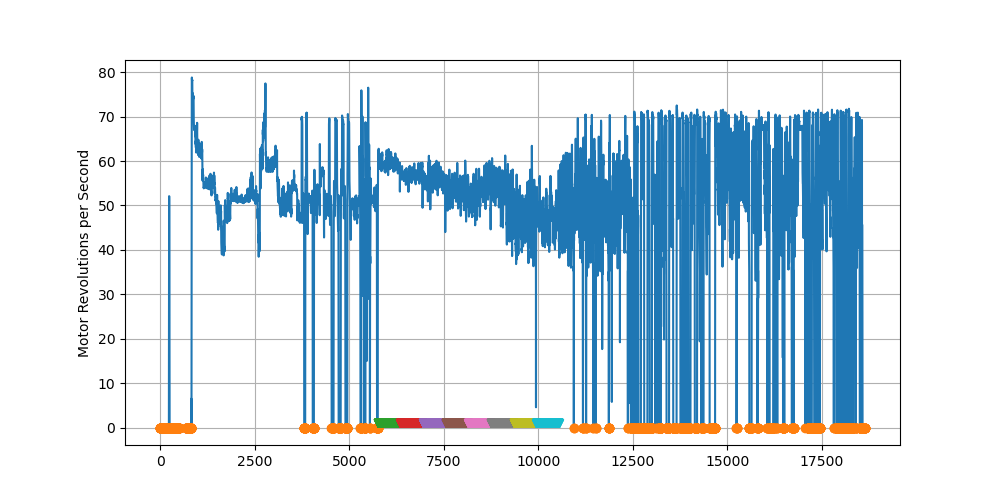

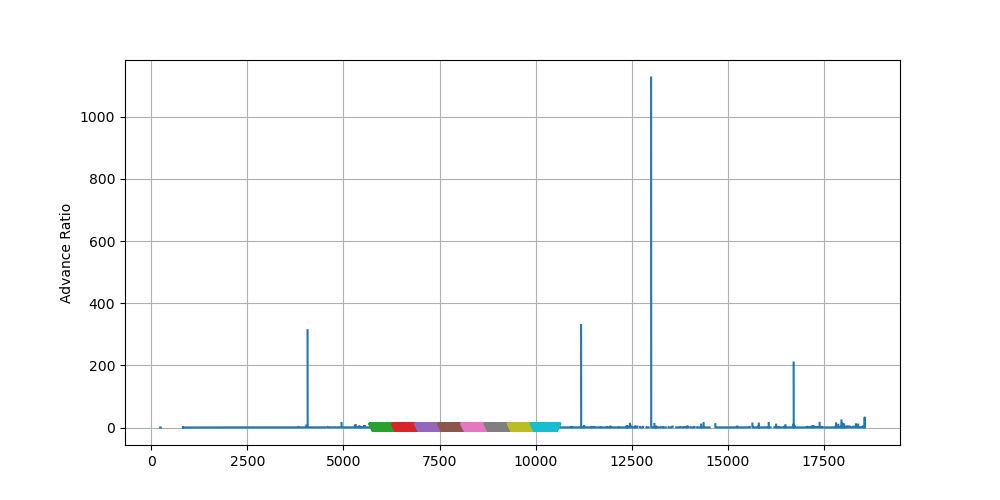

In [36]:
plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")

plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")